# Data Standardization

In this script we analyze details of the images and standardize them in a pre-processing phase (before the model training)

# Mounting google drive

In order to make it easy to read data from Google Drive, it can be mounted as a "local" unity. This encapsulates the connection to Google API and reduces the amount of coding that would be needed when interacting with Google API

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


First function to be created is a function no normalize the pixel values. This function was not used later because it was decided not to normalize the images during pre-process, as PyTorch (the framework for Deep Learning we used) has its own means for normalizing pixels.

In [ ]:
import numpy as np
def normalize(img, maxval, reshape=False):
    """Scales images to be roughly [-1024 1024]."""

    if img.max() > maxval:
        raise Exception("max image value ({}) higher than expected bound ({}).".format(img.max(), maxval))

    img = (2 * (img.astype(np.float32) / maxval) - 1.) * 1024

    if reshape:
        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")

        # add color channel
        img = img[None, :, :]

    return img

Here we load the index we have created for Train and Test images, in order to check some of the images and then make decisions around the pre-processing of them

In [ ]:
import os
import pandas as pd

base_folder = "/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project"
train_and_test = pd.read_excel(os.path.join(base_folder, "train_and_test_set.xlsx"))


In [ ]:
train_and_test[train_and_test["channel"] > 3].iloc[0]["path"]

'/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data/Train/rottenbanana/b_r344.png'

/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data/Train/freshbanana/vertical_flip_Screen Shot 2018-06-12 at 9.49.15 PM.png (432, 536, 3)


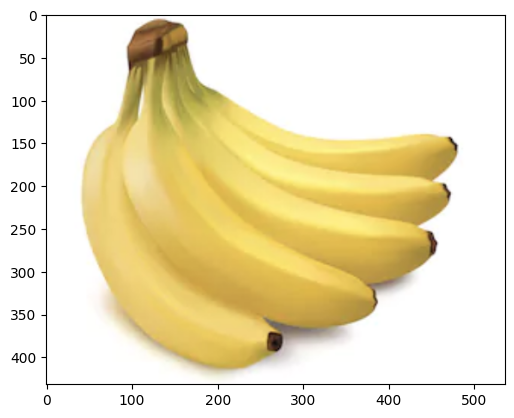

In [ ]:
import imageio.v3 as iio
import matplotlib.pyplot as plt

image_path = train_and_test.iloc[0]["path"]
image = iio.imread(image_path)
print(image_path, image.shape)
plt.imshow(image)


We used [OpenCV](https://opencv.org/), a popular library for manipulating images.

After some tests, we decided to resize all the images to 512x512 pixels, while keeping their aspect ratio by padding whenever needed with black pixels.

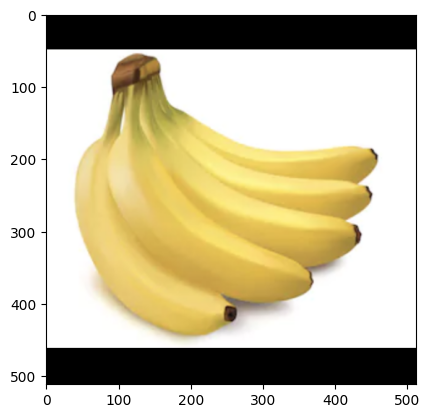

In [ ]:
import cv2
def resize_and_pad(image, height = 512, width = 512, padColor = 0):
  h, w, c = image.shape
  size = (height, width)
  sh, sw = size

  # Remove alpha channel if the image has 4 channels
  if c > 3:
    image = image[:,:,:3]

  # interpolation method
  if h > sh or w > sw: # shrinking image
    interp = cv2.INTER_AREA
  else: # stretching image
    interp = cv2.INTER_CUBIC

  # aspect ratio of image
  aspect = w/h

  # compute scaling and pad sizing
  if aspect > 1: # horizontal image
    new_w = sw
    new_h = np.round(new_w/aspect).astype(int)
    pad_vert = (sh-new_h)/2
    pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
    pad_left, pad_right = 0, 0
  elif aspect < 1: # vertical image
    new_h = sh
    new_w = np.round(new_h*aspect).astype(int)
    pad_horz = (sw-new_w)/2
    pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
    pad_top, pad_bot = 0, 0
  else: # square image
    new_h, new_w = sh, sw
    pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

  # set pad color
  if len(image.shape) == 3 and not isinstance(padColor, (list, tuple,
      np.ndarray)): # color image but only one color provided
    padColor = [padColor]*3

  # Recalc the aspect ratio
  aspect = w/h
  scaled_img = cv2.resize(image, (new_w, new_h), interpolation=interp)
  scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=0)

  return scaled_img

plt.imshow(resize_and_pad(image))

Here we developed and tested a function to get an image from the index, standardizes it (size and padding) and then save into another folder.

In [ ]:
image_info = train_and_test.iloc[0]

def standardize_images(image_info):
  # print(image_info)
  fresh_path = os.path.join(base_folder, "transformed_images", "fresh")
  if not os.path.exists(fresh_path):
    os.makedirs(fresh_path)

  not_fresh_path = os.path.join(base_folder, "transformed_images", "notfresh")
  if not os.path.exists(not_fresh_path):
    os.makedirs(not_fresh_path)

  original_path = image_info["path"]
  image = cv2.imread(original_path)
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  transformed_image = resize_and_pad(image)
  # plt.imshow(transformed_image)
  if image_info["fresh"]:
    new_placement = os.path.join(fresh_path, os.path.basename(original_path))
  else:
    new_placement = os.path.join(not_fresh_path, os.path.basename(original_path))
  cv2.imwrite(new_placement, cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))
  print(f"image {new_placement} standardized")

standardize_images(train_and_test.iloc[1])

image /content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/transformed_images/notfresh/b_r344.png standardized


In [ ]:
! pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.1 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=80dd40017bcbeeef65b2c818715b617284e71b53e56d154f780ffb75141c34fa
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


And finally we pre-processed all images again using Pandarallel for performance purposes

In [ ]:
from pandarallel import pandarallel

max_cpu_cores = os.cpu_count()

pandarallel.initialize(progress_bar = True, nb_workers = max_cpu_cores)
train_and_test = train_and_test.parallel_apply(standardize_images, axis=1)
# train_and_test.apply(standardize_images, axis=1)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Streaming output truncated to the last 5000 lines.

image /content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/transformed_images/notfresh/translation_Screen Shot 2018-06-12 at 8.58.13 PM.png standardizedimage /content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/transformed_images/fresh/rotated_by_45_Screen Shot 2018-06-12 at 9.53.41 PM.png standardized

image /content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/transformed_images/notfresh/Screen Shot 2018-06-12 at 8.57.34 PM.png standardized
image /content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/transformed_images/notfresh/rotated_by_45_Screen Shot 2018-06-12 at 8.53.29 PM.png standardized
image /content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/transformed_images/fresh/b_f030.png standardized
image /content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/transformed_images/notfresh/b_r587.png standardized
image /content/gdrive/MyDr